In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import anndata
from sklearn.decomposition import PCA

import torch
from torch import tensor as tt

from utils import *
from torch_models import *

In [25]:
# load dataset
scData = pd.read_csv("data/190923_Neuron_1.csv")
scData = scData.T
col_names = scData.iloc[0, :].values
# delete first row

scData = scData.drop(scData.index[0])
scData.columns = col_names
scData["Vip"].mean()

# create anndata object
E_sc = anndata.AnnData(scData)
E_sc.X = E_sc.X.astype(float)


In [26]:
# take the index of scData it's a list of strings
# split every string by '_' and take the first element, fro the first element remove lettter X
# and then convert to int
# this is the sample index
sample_index = np.array(
    [int(s.split("_")[0][1:]) for s in E_sc.obs.index.values.tolist()]
)
sample_index

array([14, 14, 14, ..., 58, 58, 58])

In [27]:
# remove columns/genes with all zeros
E_sc = E_sc[:, E_sc.X.sum(axis=0) != 0]
# normalize per cell
E_sc.layers["norm"] = E_sc.X / E_sc.X.sum(axis=1).reshape(-1, 1)
# now standardize the data
E_sc.layers["stand"] = (
    E_sc.layers["norm"] - E_sc.layers["norm"].mean(axis=0)
) / E_sc.layers["norm"].std(axis=0)
E_sc.obs["counts"] = E_sc.X.sum(axis=1)


In [42]:
# load the fitted coef
coef_2D = pd.read_csv(
    "fit/theta_2D.csv",
)
zonated_genes = coef_2D["Unnamed: 0"].values
theta_2D = coef_2D.values[:, 1:]
theta_2D = theta_2D.astype(float)


In [29]:
sc_zon = zonated_genes[zonated_genes != "Prokr2"]
sc_small = E_sc[:, sc_zon]

NC, NG = sc_small.shape

In [30]:
sc_small.layers["norm"].astype(float)
corr_cells = np.corrcoef(sc_small.layers["norm"].astype(float))
corr_genes = np.corrcoef(sc_small.layers["norm"].astype(float).T)


/Users/salati/miniforge3/envs/pyro/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/salati/miniforge3/envs/pyro/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [31]:
# load the fitted coef
coef_2D = pd.read_csv(
    "fit/theta_2D.csv",
)
zonated_genes = coef_2D["Unnamed: 0"].values
theta2 = coef_2D.values[:, 1:]
theta2.shape

(9, 5)

## finding seed values for x,y,z

In [32]:
zonated_counts = sc_small.X.sum(axis=1)
mask_zc = zonated_counts == 0
print(mask_zc.sum())
# now remove cells that have zeros in all zonated genes
sc_small = sc_small[~mask_zc, :]


453


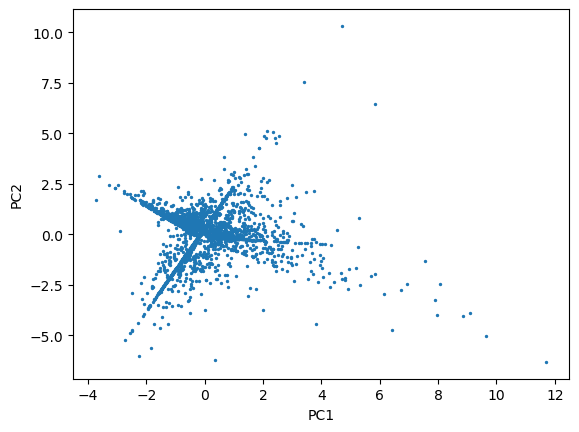

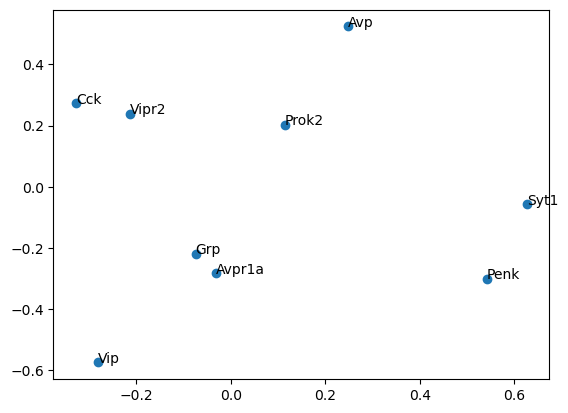

In [33]:
# perform PCA and plot the first 2 components
pca = PCA(n_components=2)
PC = pca.fit_transform(sc_small.layers["stand"])
vec = pca.components_

# plot the first 2 components
plt.scatter(PC[:, 0], PC[:, 1], s=2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# plot the loadings of the first 2 components
plt.scatter(vec[0, :], vec[1, :])
# now annotate with gene names
for i, g in enumerate(sc_zon):
    plt.annotate(g, (vec[0, i], vec[1, i]))


In [34]:
# print mean, and variance for the normalized cut of every gene, next to the gene name
for i, g in enumerate(sc_zon):
    print(g, sc_small[:, g].layers["norm"].mean(), sc_small[:, g].layers["norm"].var())

Vip 0.004168980557466908 0.00011980215386873495
Avp 0.005590197995291927 0.00017522252690295903
Prok2 6.602918039254667e-05 1.8395181801524485e-07
Penk 0.0002131344766732339 9.068027370466524e-07
Vipr2 0.0005376401553992967 9.36010444886659e-07
Avpr1a 4.151496475663759e-05 7.345211199322207e-08
Cck 0.0009145474225289935 6.680407061961441e-06
Grp 7.037686005509476e-05 3.2640422869857734e-07
Syt1 0.0005722104146576337 1.375506479785902e-06


## trying to order cells

In [35]:
order_z = np.argsort(np.argsort(sc_small[:, "Penk"].layers["norm"]))
np.argsort(sc_small[:, "Penk"].layers["norm"].squeeze()).sum()

ArrayView(4558690)

In [36]:
# now take gene Penk and get the argsort. This will give the order of the cells
# after standardize this position vecotr

# get the order of the cells
order_z = np.argsort(np.argsort(sc_small[:, "Penk"].layers["norm"]).squeeze())
z_guess = (order_z - order_z.mean()) / order_z.std()
order_z

# do the same for gene Vip
order_y = np.argsort(np.argsort(sc_small[:, "Vip"].layers["norm"]).squeeze())
y_guess = (order_y - order_y.mean()) / order_y.std()
order_y


ArrayView([   0, 2008, 2009, ..., 1011, 1002, 3019])

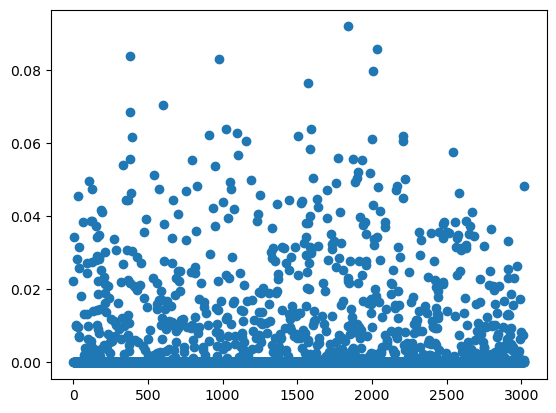

In [37]:
# plt.scatter(np.linspace(0 , 1, NC), sc_small[:, 'Penk'].layers['norm'])
plt.scatter(order_y, sc_small[:, "Vip"].layers["norm"])


# torch

In [38]:
# non leaf vectors
Y = tt(sc_small[:, :].layers["norm"])
Y_counts = tt(sc_small[:, :].X)
sc_counts = tt(sc_small.obs["counts"].values, dtype=torch.float32)

In [43]:

X = torch.randn(Y.shape[0] , 2, requires_grad=True)
theta2 = tt(theta_2D)
# convert onated dataset to tesor

disp = tt(0.3, requires_grad=True)

In [44]:
# train model

#optimizer = torch.optim.Adam([X], lr=0.001)
optimizer = torch.optim.Adam([X, disp], lr=0.001)
losses = []

for step in range(10000):
    optimizer.zero_grad()  # zero the gradients
    #output = model_2D(X, Y, theta2)
    output = model_2D_NB_batch(X, Y_counts, theta2, sc_counts, disp, batch_size=128)
    
    output.backward()  # compute the gradients
    optimizer.step()  # update the variable
    losses.append(output.detach())

disp  2.4103262
tensor(22984.4611, dtype=torch.float64)


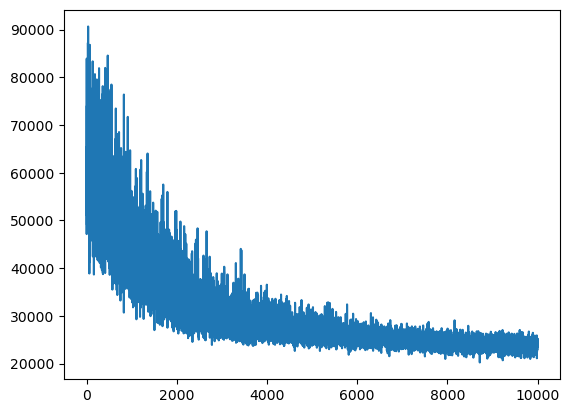

In [46]:
print('disp ', disp.detach().numpy())
print(losses[-1])
plt.plot(losses[0000:])

In [47]:
x_train = X.clone().detach().numpy()
model_2D_NB(X, Y_counts, theta2, sc_counts, disp)

tensor(23731.3031, dtype=torch.float64, grad_fn=<NegBackward0>)

Text(0, 0.5, 'z ant-post')

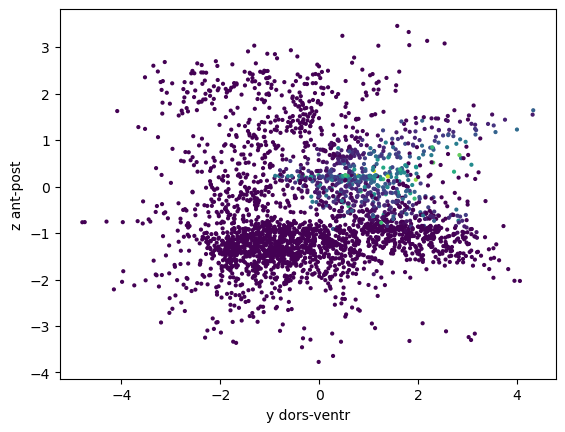

In [48]:
plt.scatter(x_train[:, 0], x_train[:, 1], c = sc_small[:, 'Vip'].layers['norm'].squeeze(), s=4)
# plt.scatter(x_train[:, 0], x_train[:, 1], c = sample_index, s=2)
plt.xlabel("y dors-ventr")
plt.ylabel("z ant-post")

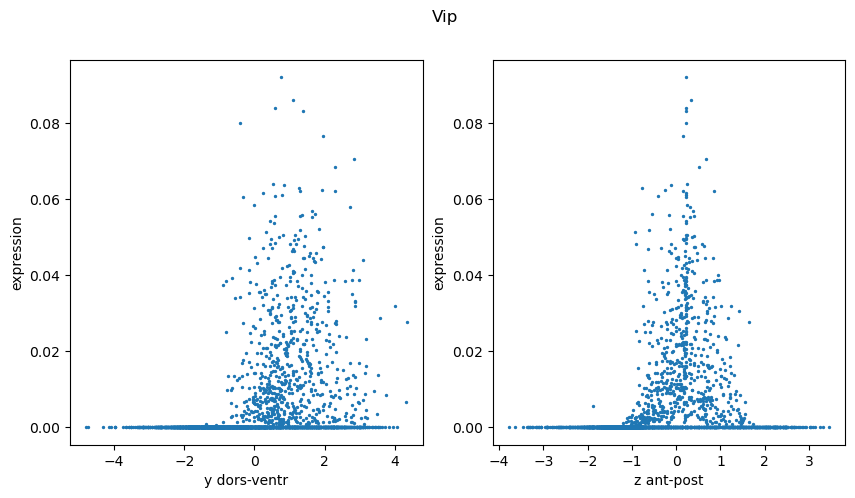

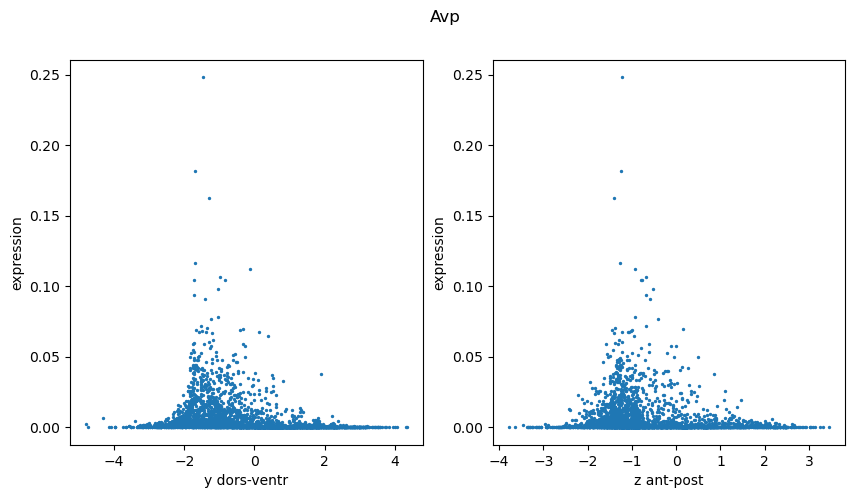

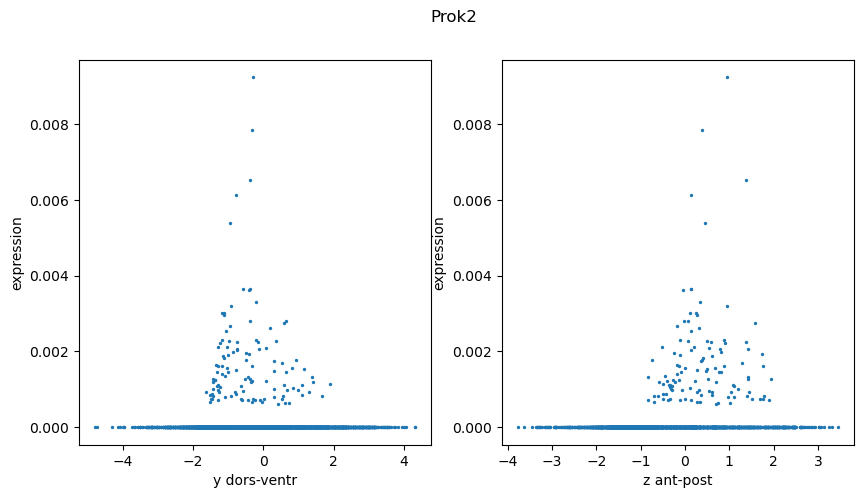

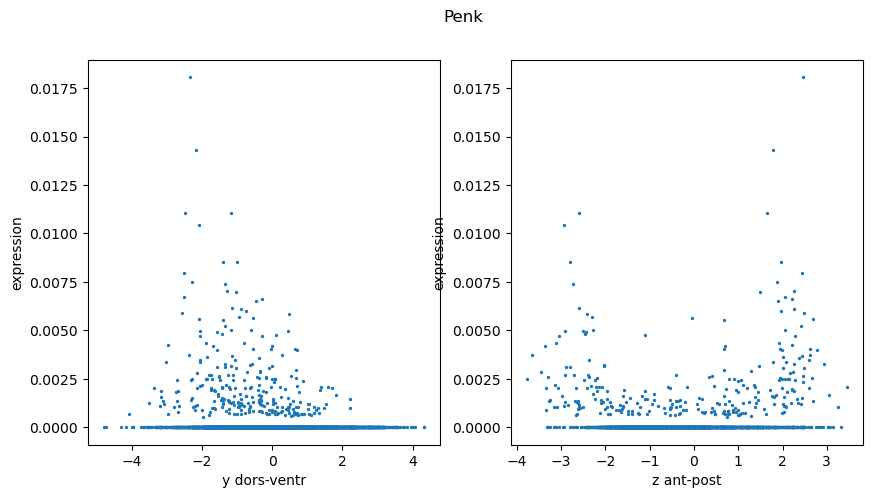

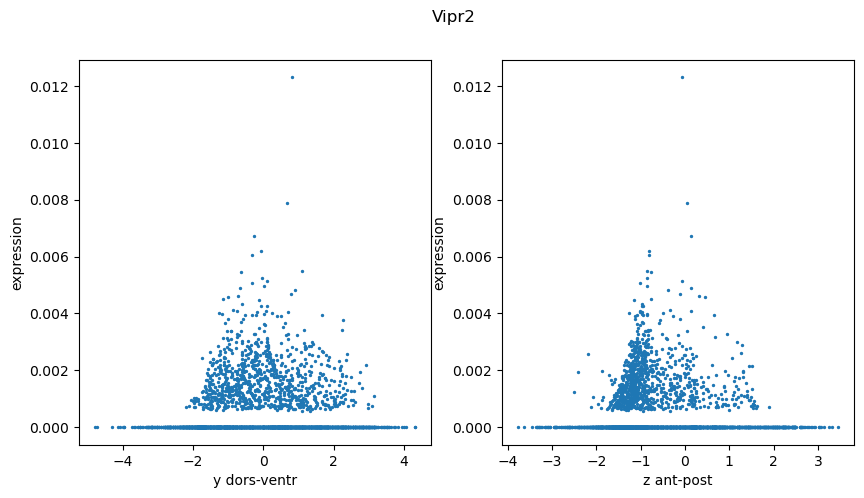

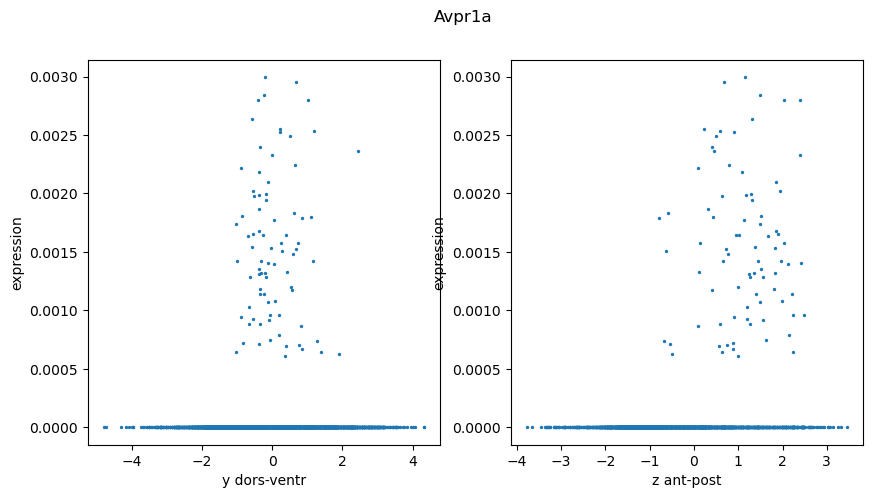

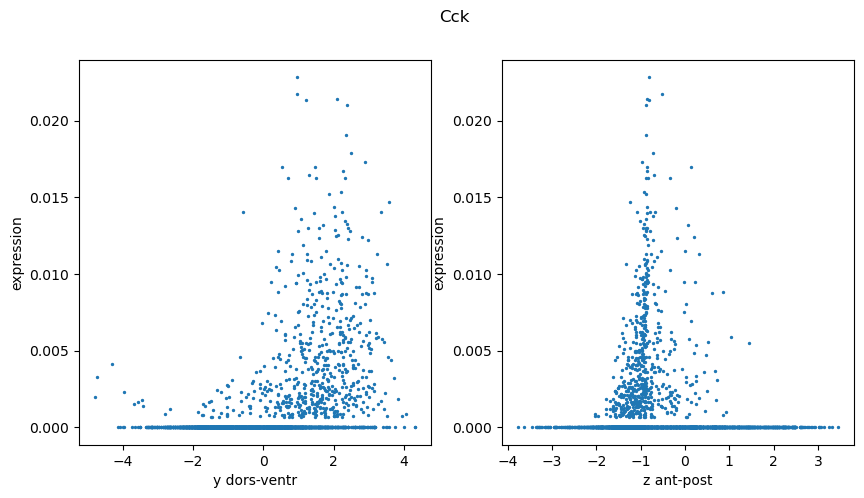

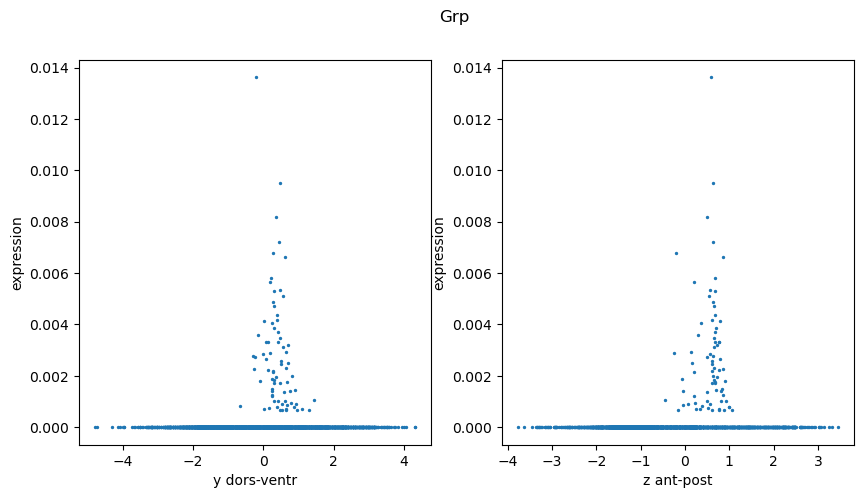

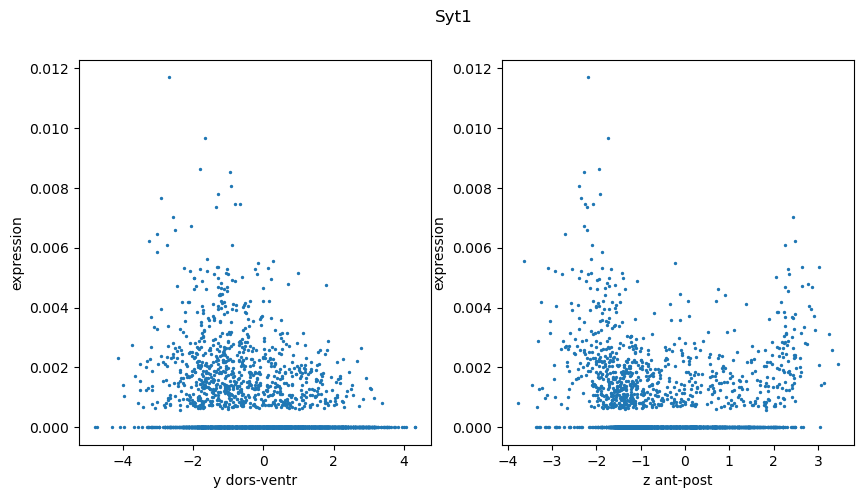

In [49]:
# plot the new x with expression of all zonated genes
# and plot the predicted fit line

for i, g in enumerate(sc_zon):
    plt.figure(figsize=(10, 5))
    plt.suptitle(g)
    plt.subplot(1, 2, 1)
    plt.scatter(x_train[:, 0], sc_small[:, g].layers["norm"], s = 2)
    plt.xlabel("y dors-ventr")
    plt.ylabel('expression')


    plt.subplot(1, 2, 2)
    plt.scatter(x_train[:, 1], sc_small[:, g].layers["norm"], s = 2)
    plt.xlabel("z ant-post")
    plt.ylabel('expression')
    
    plt.show()

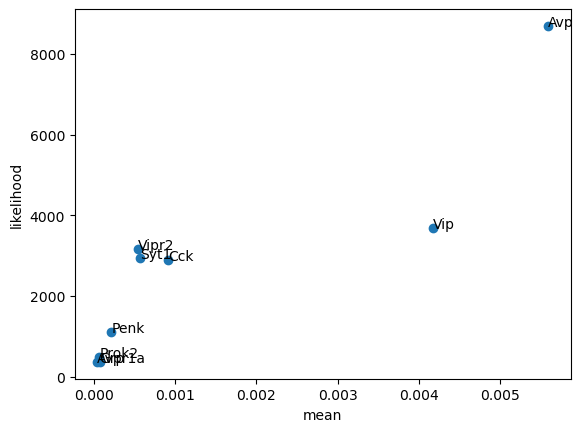

In [50]:
like = model_2D_NB_like(x_train, Y_counts, theta2, sc_counts, disp)
like_g = like.sum(axis=0).detach().numpy()

# plot now the likelihood per gene vs the gene mean
plt.scatter( sc_small[:, :].layers['norm'].mean(axis=0) , like_g)
# now add annotations
for i, g in enumerate(sc_zon):
    plt.annotate(g, (sc_small[:, :].layers['norm'].mean(axis=0)[i], like_g[i]))


plt.xlabel('mean')
plt.ylabel('likelihood')
plt.show()

# phases

In [51]:
# load daset
time = pd.read_csv("data/190923_Neuron_1_metadata.csv")
time = time.iloc[~mask_zc, :]
print(time.shape)
time.head()


(3020, 5)


,Unnamed: 0,phase_hr_mod,phase_inf,labels,cell_barcode
0,1,14,23.291099,14,14_AAAAGGGGCCGT
1,2,14,18.018134,14,14_AAAGCGCGCTAA
2,3,14,15.120667,14,14_AAATCATGTGTA
4,5,14,17.767185,14,14_AACCTTCCCAGG
5,6,14,18.794643,14,14_AAGAGCGGTCGA


In [52]:
labels = time['labels'].values
phase_inf = time['phase_inf'].values

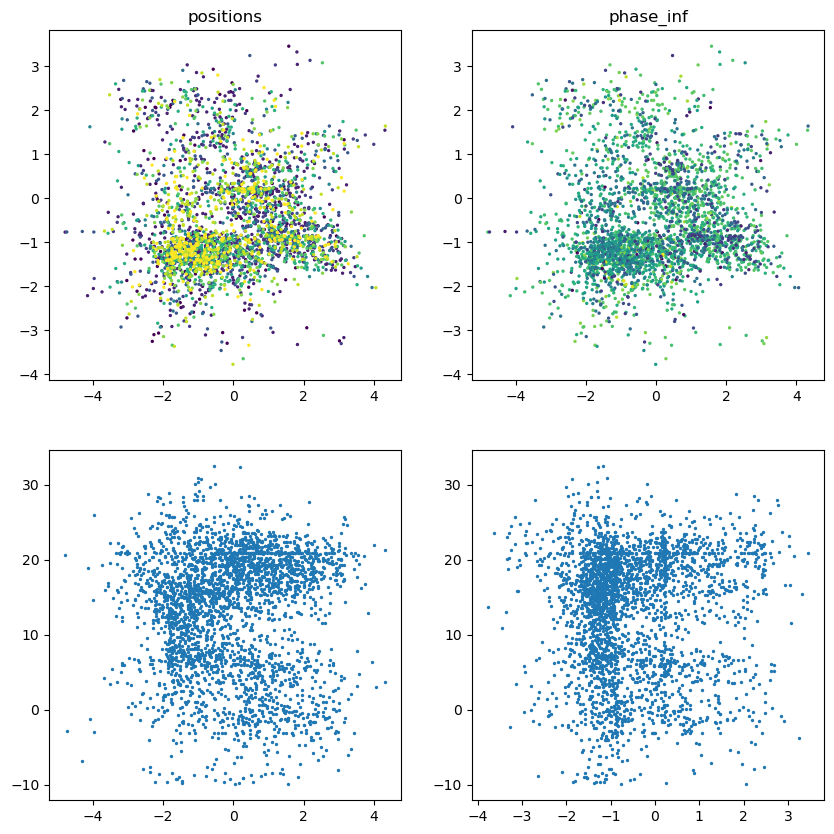

In [54]:
# quadruple plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(x_train[:, 0], x_train[:, 1],  c=labels, s=2)
axs[0, 0].set_title("positions")

axs[0, 1].scatter(x_train[:, 0], x_train[:, 1],  c=phase_inf, s=2)
axs[0, 1].set_title("phase_inf")

axs[1, 0].scatter(x_train[:, 0], phase_inf, s=2)
axs[1, 1].scatter(x_train[:, 1], phase_inf, s=2)


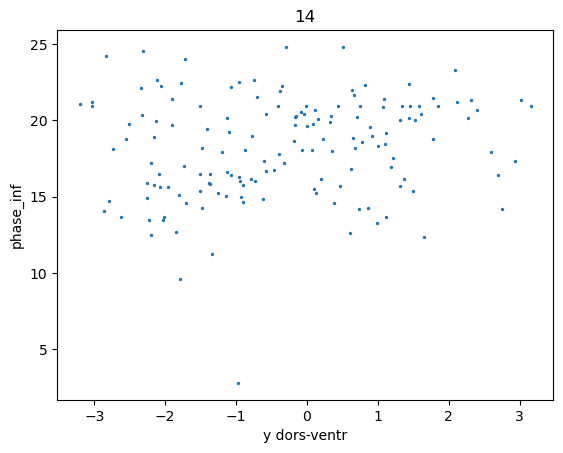

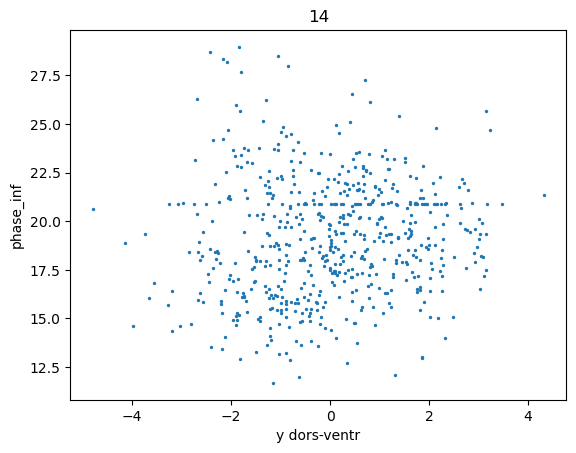

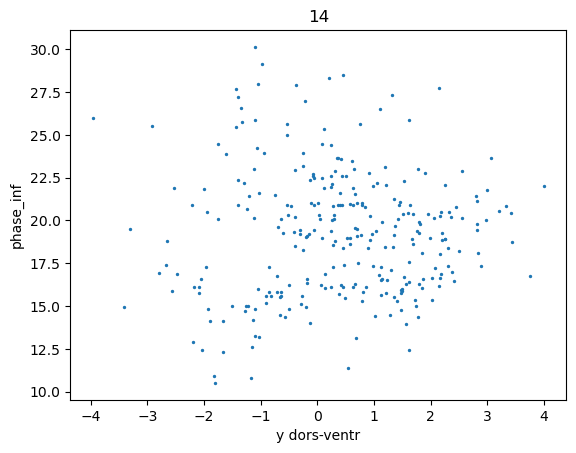

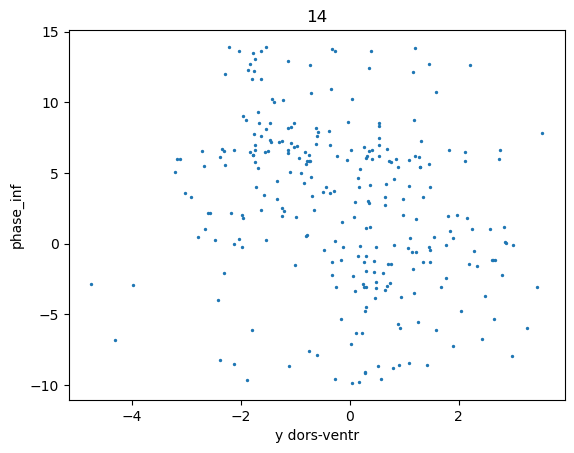

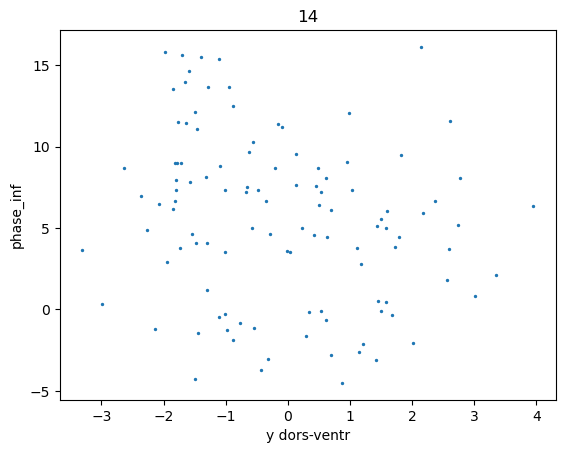

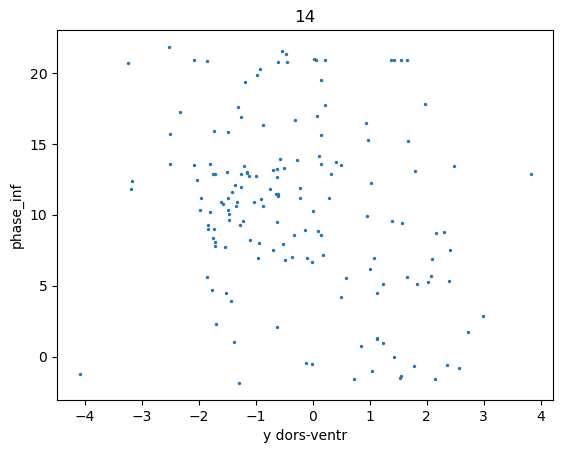

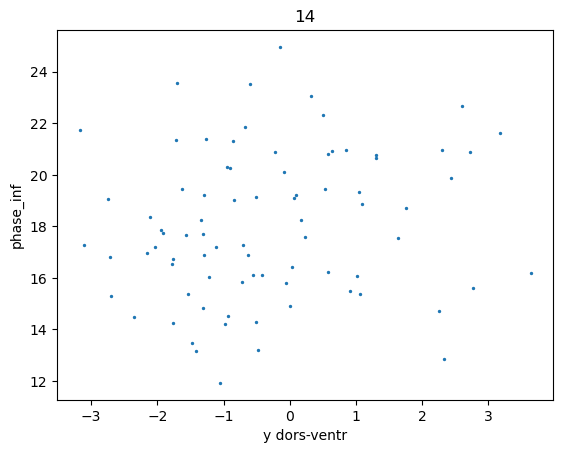

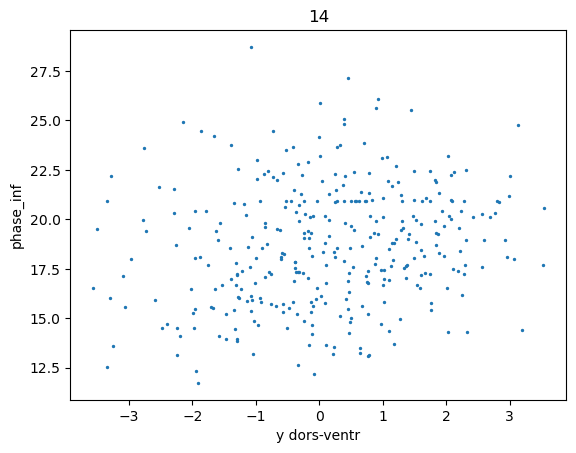

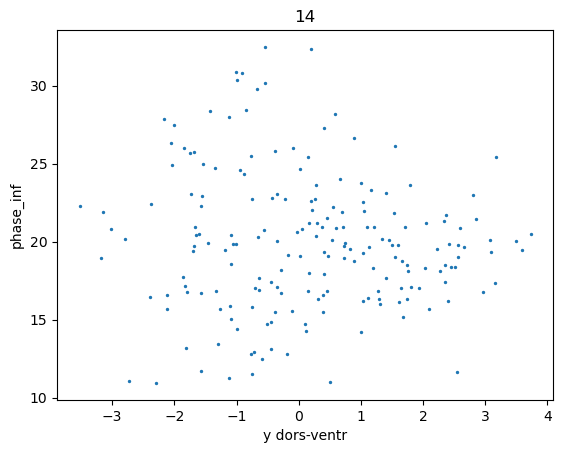

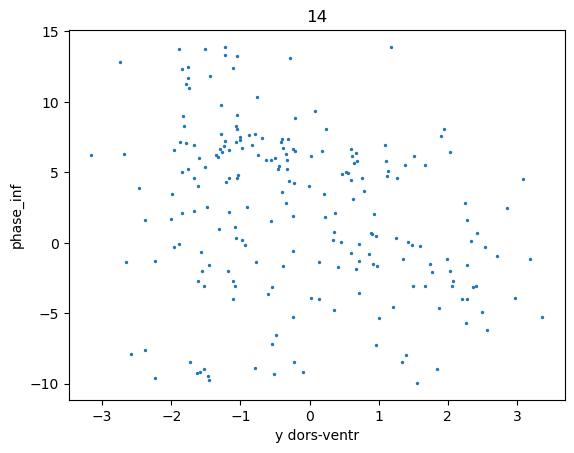

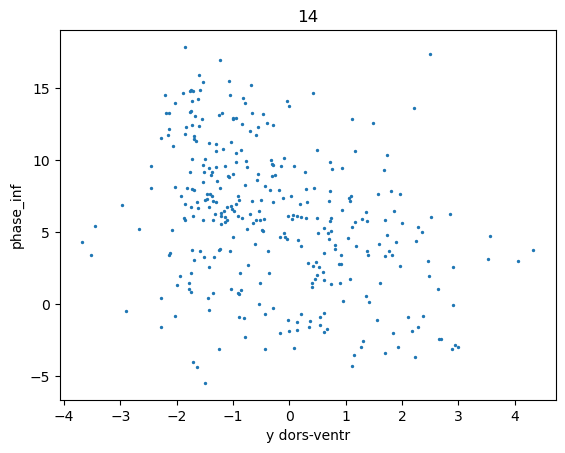

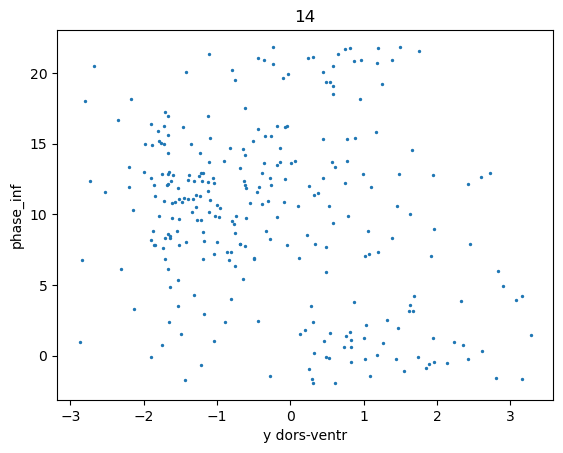

In [55]:
mask = labels == 14

for i in np.unique(labels):
    mask = labels == i
    plt.scatter(x_train[mask, 0], phase_inf[mask],  s=2)
    plt.xlabel("y dors-ventr")
    plt.ylabel("phase_inf")
    plt.title('14')
    plt.show()